### 使用双向GRU对异常子序列进行分类

In [3]:
from torch import nn
input_dim = 10
embedding_dim = 2
embedding = nn.Embedding(input_dim, embedding_dim)
err = True
if err:
    #Any input more than input_dim - 1, here input_dim = 10
    #Any input less than zero
    input_to_embed = torch.tensor([10])
else:
    input_to_embed = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
embed = embedding(input_to_embed)
print(embed)

IndexError: index out of range in self

In [2]:
import torch, time, math
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Parameters
HIDDEN_SIZE = 200
BATCH_SIZE = 200 #每一批训练10个异常子序列中的相同位置的数据
N_LAYER = 2
N_EPOCHS = 10 #训练周期
N_CHARS = 1500 #输入字符集128个字典长度
USE_GPU = False



class SequenceDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = 'train.csv' if is_train_set else 'test.csv'
        with open(filename, 'rt') as f:
            next(f)   # skip the first line
            reader = csv.reader(f)
            rows = list(reader) #读取数据，以元组形式（name,country)
        self.sequences = [str(row[0:-1]) for row in rows] #把异常子序列放在names列表中
        self.len = len(self.sequences) #求出所有名字的个数
        self.classes = [row[-1] for row in rows] #把异常子序列标签放在countries列表中
        self.class_list = list(sorted(set(self.classes))) #把异常子序列类别去重并排序，然后转为列表
        self.class_num = len(self.class_list) #求出异常子序列类别个数
    def __getitem__(self, index):
        return self.sequences[index], self.classes[index] #拿出的名字是异常子序列串，拿出的国家是标签
    def __len__(self):
        return self.len #返回名字个数，即数据集的长度
    def getclassesNum(self):
        return self.class_num#获得异常子序列的类别个数

trainset = SequenceDataset(is_train_set=True)#获取训练集，每批10个异常子序列中的某个数据
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = SequenceDataset(is_train_set=False)#获取测试集，每批10个异常子序列中的某个数据
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
N_COUNTRY = trainset.getclassesNum()#获得异常类别数量，决定模型最终输出的维度大小

class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        #没有层数输入时，默认选用1层双向GRU，输出两个hidden，hf,hb
        #RNNClassifier(N_CHARS=1500, HIDDEN_SIZE=200, N_COUNTRY=2, N_LAYER=2)
        
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size#200
        self.n_layers = n_layers#2
        self.n_directions = 2 if bidirectional else 1
        
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        #(1500，200)，embedding输入(seqlen,batchsize),输出(seqlen,batchsize,hiddensize)，将名字和字母嵌入成gru要求的输入的形式
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        #GRU输入(seqlen,batch_size,hidden_size)，hidden(𝑛𝐿𝑎𝑦𝑒𝑟𝑠∗𝑛𝐷𝑖𝑟𝑒𝑐𝑡𝑖𝑜𝑛𝑠,𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒,ℎ𝑖𝑑𝑑𝑒𝑛𝑆𝑖𝑧𝑒)
        #GRU输出𝑜𝑢𝑡𝑝𝑢𝑡:𝑠𝑒𝑞𝐿𝑒𝑛,𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒,ℎ𝑖𝑑𝑑𝑒𝑛𝑆𝑖𝑧𝑒∗𝑛𝐷𝑖𝑟𝑒𝑐𝑡𝑖𝑜𝑛𝑠，hidden(𝑛𝐿𝑎𝑦𝑒𝑟𝑠∗𝑛𝐷𝑖𝑟𝑒𝑐𝑡𝑖𝑜𝑛𝑠,𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒,ℎ𝑖𝑑𝑑𝑒𝑛𝑆𝑖𝑧𝑒)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)
        #再经过fc将(s,b,h*nd)转为(s,b,o)，然后用交叉熵计算损失来训练
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)#h0为(nl*nd,b,h)的全0初始隐藏层
        return create_tensor(hidden)
    
    def forward(self, input_, seq_lengths):
        #output = classifier(inputs, seq_lengths)
        # input shape : B x S --> S x B，B是每批次取的名字数量，S是每个名字的字母长度，竖排变横排，即对应字母对齐变横排
        input_ = input_.t()#转置为seqlen x batch_size
        batch_size = input_.size(1)#每批次取的名字数量256,为了初始化h0
        
        hidden = self._init_hidden(batch_size)#生成（2*2，10，200）全0
        embedding = self.embedding(input_)#30*10,600->43*10*200
        #(600，200)，embedding输入(seqlen名字长度,batchsize选一批名字),输出(seqlen,batchsize,200)，将名字和字母嵌入成gru要求的输入的形式
        
        # pack them up，为了提高运行效率，面对序列长短不一时支持提速，目的是使填充为0的数据不需要参与运算，生成一个打包的对象
        #（一个长条的向量，每一小段向量对应一个字符串里不为0的数据序列，且是降序排序好的）
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths) #输出见p67页
        #seq_lengths：每个batch里名字字母序列长度放到列表里给它，经过packed后返回一个打包的Squence对象(data是按batch竖排的数据，batch)。
        
        output, hidden = self.gru(gru_input, hidden)#要了解以下GRU的结构
        #The output is a PackedSequence object, actually it is a tuple。输出hidden是(nl*nd,b,h)
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat)
        return fc_output.view(-1, N_COUNTRY)

def sequence2list(sequences):
    #返回字符对应的每个字母的十进制整数，这个十进制数其实对应的是独热向量，在嵌入的时候只要告诉他ascii码值就行
    arr_temp = []
    arr_temp1 = []
    for sequence in sequences:
        sequence = sequence.strip("']['").split("', '")
#         print(sequence)
        sequence = np.array([float(c) for c in sequence])
        sequence = np.round(sequence,2)
        arr_temp.append(sequence)
    sequence_min = np.min(arr_temp)
    arr = []
    for sequence in arr_temp: 
        arr_temp1 = [int((c-sequence_min)/0.01) for c in sequence]
        arr.append((arr_temp1,len(arr_temp1)))
#     print(arr)
    return arr

def create_tensor(tensor):
    if USE_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor

#长度一样的序列可以不用排序
def make_tensors(sequences, classes):
    sequences_and_lengths = sequence2list(sequences)#[(每个序列的数字十进制数列表，序列的长度),....]
    seq_tensor = torch.LongTensor([s1[0] for s1 in sequences_and_lengths])#取出名字十进制数列表，num*名字十进制列表
    seq_lengths = torch.LongTensor([s1[1] for s1 in sequences_and_lengths])#取出名字长度列表转为longtensor，[seqlen]
    classes = torch.LongTensor(np.array(classes).astype(int).tolist())#将国家转为longtensor
    
    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(classes)

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m*60
    return '%dm %ds' % (m,s)

def drawAcc(acc_list):
    epoch = np.arange(1, len(acc_list)+1, 1)
    acc_list = np.array(acc_list)
    plt.plot(epoch, acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

def trainModel():
    total_loss = 0
    for i, (sequences, classes) in enumerate(train_loader, 1):#取出名字和国家
        inputs, seq_lengths, target = make_tensors(sequences, classes)#排序后的十进制矩阵，排序后的序列长度列表，排序后的国家列表
#         print(inputs)
#         print(seq_lengths)
#         print(target)
        output = classifier(inputs, seq_lengths)
#         print(output)
        
        loss = criterion(output, target)
#         print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #每5个batch输出一次
        if i % 2 == 0:
            print(f'[{time_since(start)}] Epoch {epoch}', end='')
            print(f'[{i * len(inputs)} / {len(trainset)}]',end='')#每批10,每5批输出一次损失
            print(f'loss={total_loss / (i * len(inputs))}')
    return total_loss

def testModel():
    correct = 0
    total = len(testset)
    print("evaluating trained model ...")
    with torch.no_grad():
        for i, (sequences, classes) in enumerate(test_loader, 1):
            inputs, seq_lengths, target = make_tensors(sequences, classes)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
#             print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        percent = '%.2f' % (100 * correct/total)
        print(f'Test set:Accuracy {correct}/{total} {percent}%')
    return correct/total


if __name__ == '__main__':
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)#N_CHARS
    #def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True)
    #是否用GPU跑
    if USE_GPU:
        device = torch.device("cuda:0")
        classifier.to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    start = time.time()
    print("Training for %d epochs..." % N_EPOCHS)
    print('-'*50)
    acc_list = []
    best_model = 0
    for epoch in range(1 , N_EPOCHS + 1):
        # Train cycle
        trainModel()
        acc = testModel()
        acc_list.append(acc)
        print('='*24+str(epoch)+'='*24)
        # 保存神经网络
        if acc > best_model:
            best_model = acc
            torch.save(classifier, 'best_classifier_model.pkl')           # 保存整个神经网络的结构和模型参数 

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

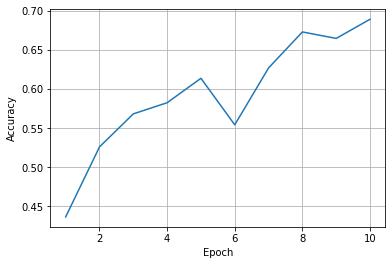

In [3]:
#画出epoch和准确度变化曲线
drawAcc(acc_list)

In [21]:
# 载入整个神经网络的结构及其模型参数 ,查看最优的模型，并用于异常子序列分类任务

class SequenceDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = 'train.csv' if is_train_set else 'real_test.csv'
        with open(filename, 'rt') as f:
            next(f)   # skip the first line
            reader = csv.reader(f)
            rows = list(reader) #读取数据，以元组形式（name,country)
#         self.flarename = [row[0] for row in rows]
        self.sequences = [str(row[2:-1]) for row in rows] #把异常子序列放在names列表中
        self.len = len(self.sequences) #求出所有名字的个数
        self.classes = [row[-1] for row in rows] #把异常子序列标签放在countries列表中
        self.class_list = list(sorted(set(self.classes))) #把异常子序列类别去重并排序，然后转为列表
        self.class_num = len(self.class_list) #求出异常子序列类别个数
    def __getitem__(self, index):
        return self.sequences[index], self.classes[index] #拿出的名字是异常子序列串，拿出的国家是标签
    def __len__(self):
        return self.len #返回名字个数，即数据集的长度
    def getclassesNum(self):
        return self.class_num#获得异常子序列的类别个数

testset = SequenceDataset(is_train_set=False)#获取测试集，每批10个异常子序列中的某个数据
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
N_COUNTRY = trainset.getclassesNum()#获得异常类别数量，决定模型最终输出的维度大小


def testModel():
    correct = 0
    total = len(testset)
    print("evaluating trained model ...")
    with torch.no_grad():
        for i, (sequences, classes) in enumerate(test_loader, 1):
            inputs, seq_lengths, target = make_tensors(sequences, classes)
#             print(target)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            
            correct += pred.eq(target.view_as(pred)).sum().item()
            with open('./real_test_label.csv', 'a+', newline='') as f:
#                 next(f)   # skip the first line
                csv_writer = csv.writer(f)
                for l in pred:
                    csv_writer.writerow(l)    
        
        
        percent = '%.2f' % (100 * correct/total)
        print(f'Test set:Accuracy {correct}/{total} {percent}%')
    return correct/total

classifier = torch.load('best_classifier_model.pkl')
acc = testModel()

evaluating trained model ...
Test set:Accuracy 6589/10000 65.89%
